In [4]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from PIL import Image, ImageDraw, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import cv2


def get_trained_model(num_classes, model_path):
    model = maskrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def predict(model, image_path, device):
    img = Image.open(image_path).convert("RGB")
    img = ImageOps.exif_transpose(img)  
    img_tensor = F.to_tensor(img).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(img_tensor)

    return img, prediction

def visualize_prediction(img, prediction, threshold=0.5):
    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()
    pred_masks = prediction[0]['masks'].cpu().numpy()
    pred_labels = prediction[0]['labels'].cpu().numpy()

    img_with_masks = img.copy().convert("RGBA")
    img_array = np.array(img_with_masks)
    overlay = img_array.copy()

    for i, score in enumerate(pred_scores):
        if score > threshold:
            print(f"Predicted class: {pred_labels[i]}")
            mask = pred_masks[i][0]
            mask = (mask > 0.5).astype(np.uint8)  # Binarize the mask
            contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                cv2.drawContours(overlay, [contour], -1, (255, 0, 255, 255), thickness=2)  

            purple_mask = np.zeros_like(img_array)
            purple_mask[:, :, 0] = 255  # Red channel
            purple_mask[:, :, 2] = 255  # Blue channel
            purple_mask[:, :, 3] = 128  # Alpha channel
            mask_expanded = np.expand_dims(mask, axis=2)
            overlay = np.where(mask_expanded, purple_mask, overlay)

    combined = Image.alpha_composite(Image.fromarray(img_array), Image.fromarray(overlay))

    plt.figure(figsize=(10, 10))
    plt.imshow(combined)
    plt.axis('off')
    plt.show()




C:\Users\wjc20\AppData\Local\Temp\ipykernel_20780\666214535.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Predicted class: 1


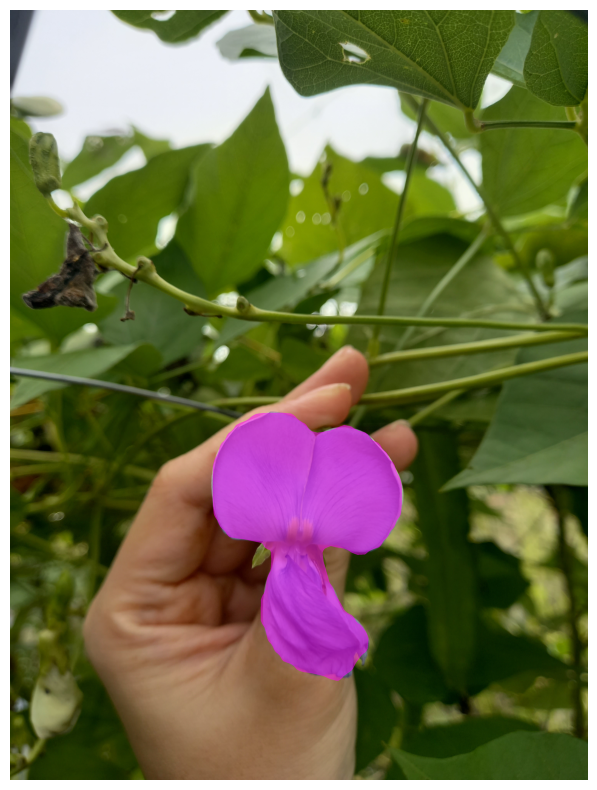

In [5]:
if __name__ == "__main__":
    model_path = "mask_rcnn_model.pth"  # Replace with the actual model weight file path
    image_path = "Flower141.jpg"  # Replace with the actual image file path
    num_classes = 4  # Adjust the number of classes according to your dataset

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = get_trained_model(num_classes, model_path)
    model.to(device)

    img, prediction = predict(model, image_path, device)
    visualize_prediction(img, prediction)

In [3]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from PIL import Image, ImageDraw, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import cv2

def get_trained_model(num_classes, model_path):
    model = maskrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def predict(model, image_path, device):
    img = Image.open(image_path).convert("RGB")
    img = ImageOps.exif_transpose(img)  
    img_tensor = F.to_tensor(img).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(img_tensor)

    return img, prediction

def visualize_prediction(img, prediction, threshold=0.5):
    colors = {
        1: ([255, 0, 255, 128], [255, 0, 255, 255]),  # Light purple for flower
        2: ([255, 100, 100, 128], [255, 100, 100, 255]),  # Light red for pod
        3: ([205, 133, 63, 128], [205, 133, 63, 255])  # Light brown for seed
    }

    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()
    pred_masks = prediction[0]['masks'].cpu().numpy()
    pred_labels = prediction[0]['labels'].cpu().numpy()

    img_with_masks = img.copy().convert("RGBA")
    img_array = np.array(img_with_masks)
    overlay = img_array.copy()

    for i, score in enumerate(pred_scores):
        if score > threshold:
            label = pred_labels[i]
            print(f"Predicted class: {label}")
            mask = pred_masks[i][0]
            mask = (mask > 0.5).astype(np.uint8)  # Binarize the mask
            contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            color_overlay, color_contour = colors.get(label, ([255, 255, 255, 128], [255, 255, 255, 255]))  # default to white

            for contour in contours:
                cv2.drawContours(overlay, [contour], -1, tuple(color_contour), thickness=2)  # 绘制边线

            color_mask = np.zeros_like(img_array)
            color_mask[:, :, 0] = color_overlay[0]  # Red channel
            color_mask[:, :, 1] = color_overlay[1]  # Green channel
            color_mask[:, :, 2] = color_overlay[2]  # Blue channel
            color_mask[:, :, 3] = color_overlay[3]  # Alpha channel
            mask_expanded = np.expand_dims(mask, axis=2)
            overlay = np.where(mask_expanded, color_mask, overlay)

    combined = Image.alpha_composite(Image.fromarray(img_array), Image.fromarray(overlay))

    plt.figure(figsize=(10, 10))
    plt.imshow(combined)
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    model_path = "mask_rcnn_model.pth"  # Replace with the actual model weight file path
    image_path = "Seed6.jpg"  # Replace with the actual image file path
    num_classes = 4  # Adjust the number of classes according to your dataset

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = get_trained_model(num_classes, model_path)
    model.to(device)

    img, prediction = predict(model, image_path, device)
    visualize_prediction(img, prediction)


C:\Users\wjc20\AppData\Local\Temp\ipykernel_4368\3847830046.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Predicted class: 3
Predicted class: 3
Predicted class: 3
Predicted class: 3
Predicted class: 3
Predicted class: 3
Predicted class: 3
Predicted class: 3
Predicted class: 3
Predicted class: 3
Predicted class: 3
Predicted class: 3
Predicted class: 3
Predicted class: 3
Predicted class: 3
Predicted class: 3
Predicted class: 3
Predicted class: 3
Predicted class: 3
Predicted class: 3
Predicted class: 3
Predicted class: 3


C:\Users\wjc20\AppData\Local\Temp\ipykernel_4368\218518673.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Predicted class: 2


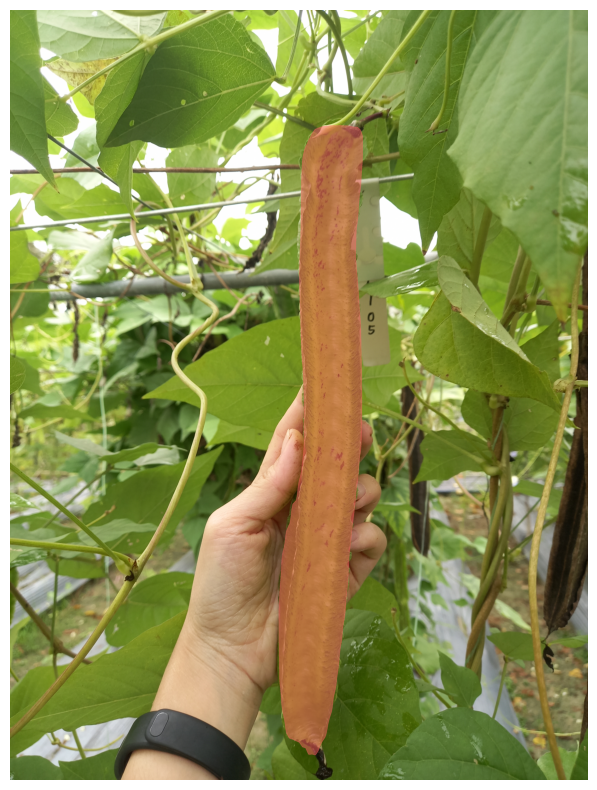

In [4]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from PIL import Image, ImageDraw, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import cv2

def get_trained_model(num_classes, model_path):
    model = maskrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def predict(model, image_path, device):
    img = Image.open(image_path).convert("RGB")
    img = ImageOps.exif_transpose(img)  # 自动调整图像方向
    img_tensor = F.to_tensor(img).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(img_tensor)

    return img, prediction

def visualize_prediction(img, prediction, threshold=0.5):
    colors = {
        1: ([255, 0, 255, 128], [255, 0, 255, 255]),  # Light purple for flower
        2: ([255, 100, 100, 128], [255, 100, 100, 255]),  # Light red for pod
        3: ([205, 133, 63, 128], [205, 133, 63, 255])  # Light brown for seed
    }

    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()
    pred_masks = prediction[0]['masks'].cpu().numpy()
    pred_labels = prediction[0]['labels'].cpu().numpy()

    img_with_masks = img.copy().convert("RGBA")
    img_array = np.array(img_with_masks)
    overlay = img_array.copy()

    for i, score in enumerate(pred_scores):
        if score > threshold:
            label = pred_labels[i]
            print(f"Predicted class: {label}")
            mask = pred_masks[i][0]
            mask = (mask > 0.5).astype(np.uint8)  # Binarize the mask
            contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            color_overlay, color_contour = colors.get(label, ([255, 255, 255, 128], [255, 255, 255, 255]))  # default to white

            for contour in contours:
                cv2.drawContours(overlay, [contour], -1, tuple(color_contour), thickness=2)  # 绘制边线

            color_mask = np.zeros_like(img_array)
            color_mask[:, :, 0] = color_overlay[0]  # Red channel
            color_mask[:, :, 1] = color_overlay[1]  # Green channel
            color_mask[:, :, 2] = color_overlay[2]  # Blue channel
            color_mask[:, :, 3] = color_overlay[3]  # Alpha channel
            mask_expanded = np.expand_dims(mask, axis=2)
            overlay = np.where(mask_expanded, color_mask, overlay)

    combined = Image.alpha_composite(Image.fromarray(img_array), Image.fromarray(overlay))

    plt.figure(figsize=(10, 10))
    plt.imshow(combined)
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    model_path = "mask_rcnn_model.pth"  # Replace with the actual model weight file path
    image_path = "Pod54.jpg"  # Replace with the actual image file path
    num_classes = 4  # Adjust the number of classes according to your dataset

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = get_trained_model(num_classes, model_path)
    model.to(device)

    img, prediction = predict(model, image_path, device)
    visualize_prediction(img, prediction)


In [6]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from PIL import Image, ImageDraw, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import cv2

def get_trained_model(num_classes, model_path):
    model = maskrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def predict(model, image_path, device):
    img = Image.open(image_path).convert("RGB")
    img = ImageOps.exif_transpose(img)  
    img_tensor = F.to_tensor(img).unsqueeze(0).to(device)
    with torch.no_grad():
        prediction = model(img_tensor)

    return img, prediction

def visualize_prediction(img, prediction, threshold=0.5):
    colors = {
        1: ([255, 0, 255, 128], [255, 0, 255, 255]),  # Light purple for flower
        2: ([255, 100, 100, 128], [255, 100, 100, 255]),  # Light red for pod
        3: ([205, 133, 63, 128], [205, 133, 63, 255])  # Light brown for seed
    }

    pred_boxes = prediction[0]['boxes'].cpu().numpy()
    pred_scores = prediction[0]['scores'].cpu().numpy()
    pred_masks = prediction[0]['masks'].cpu().numpy()
    pred_labels = prediction[0]['labels'].cpu().numpy()

    img_with_masks = img.copy().convert("RGBA")
    img_array = np.array(img_with_masks)
    overlay = img_array.copy()

    for i, score in enumerate(pred_scores):
        if score > threshold:
            label = pred_labels[i]
            print(f"Predicted class: {label}")
            mask = pred_masks[i][0]
            mask = (mask > 0.5).astype(np.uint8)  # Binarize the mask
            contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            color_overlay, color_contour = colors.get(label, ([255, 255, 255, 128], [255, 255, 255, 255]))  # default to white

            for contour in contours:
                cv2.drawContours(overlay, [contour], -1, tuple(color_contour), thickness=2)  

            color_mask = np.zeros_like(img_array)
            color_mask[:, :, 0] = color_overlay[0]  # Red channel
            color_mask[:, :, 1] = color_overlay[1]  # Green channel
            color_mask[:, :, 2] = color_overlay[2]  # Blue channel
            color_mask[:, :, 3] = color_overlay[3]  # Alpha channel
            mask_expanded = np.expand_dims(mask, axis=2)
            overlay = np.where(mask_expanded, color_mask, overlay)

    combined = Image.alpha_composite(Image.fromarray(img_array), Image.fromarray(overlay))

    plt.figure(figsize=(10, 10))
    plt.imshow(combined)
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    model_path = "mask_rcnn_model.pth"  # Replace with the actual model weight file path
    image_path = "mix.jpg"  # Replace with the actual image file path
    num_classes = 4  # Adjust the number of classes according to your dataset

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = get_trained_model(num_classes, model_path)
    model.to(device)

    img, prediction = predict(model, image_path, device)
    visualize_prediction(img, prediction)


C:\Users\wjc20\AppData\Local\Temp\ipykernel_4368\2443947716.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Predicted class: 1
Predicted class: 2
